# Importing Libraries

In [4]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Collecting Data

In [8]:
!pip install yfinance
import yfinance as yf

# Pre-Processing

In [9]:
def stock_data(stock, start_date, end_date):

    tickerSymbol = stock

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

    return tickerDf


In [11]:
df = stock_data("ITC.BO", "2012-07-02", "2022-07-02")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-07-02,132.951948,133.981781,127.545304,128.781113,543328,0.0,0.0
2012-07-03,128.781132,128.832623,126.361017,127.107643,773637,0.0,0.0
2012-07-04,128.137455,128.214698,125.949056,126.747185,414553,0.0,0.0
2012-07-05,126.927394,129.090054,126.875903,128.755356,271848,0.0,0.0
2012-07-06,128.729633,130.531844,128.085977,130.119904,372049,0.0,0.0


# Exploratory Data Analysis

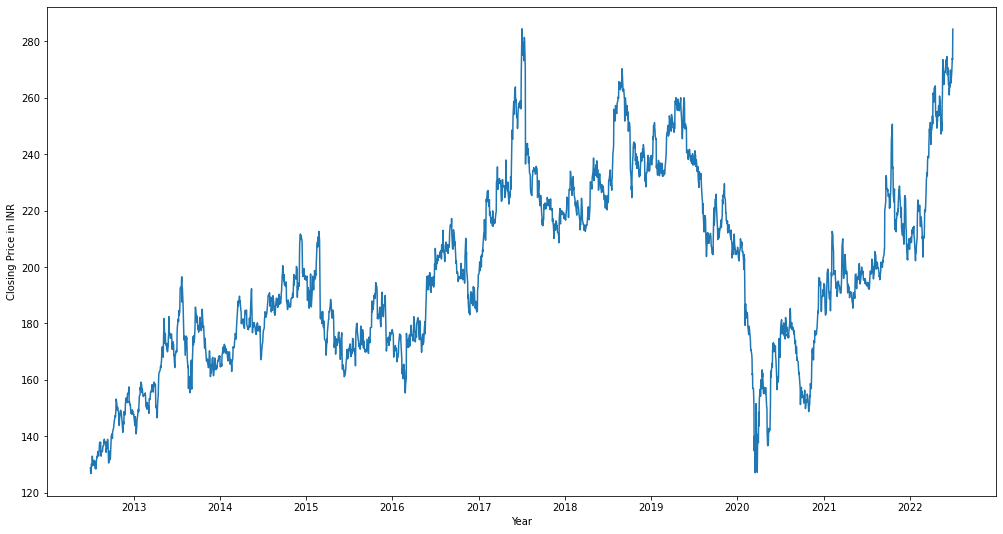

In [13]:
#plotting fetched data
fig = plt.figure(figsize=(17,9))
plt.xlabel("Year")
plt.ylabel("Closing Price in INR")
plt.plot(df['Close'], label='Close Price history')

In [14]:
#Checking the data types
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [15]:
#Checking for data consistency, missing values, measures of central tendency, dispersion
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2465.000000,2465.000000,2465.000000,2465.000000,2.465000e+03,2465.000000,2465.000000
mean,198.048003,199.959737,195.674977,197.710733,9.447903e+05,0.024767,0.000609
std,32.550799,32.752253,32.341327,32.446892,1.028386e+06,0.379964,0.030212
min,126.927394,128.214698,116.489332,126.747185,0.000000e+00,0.000000,0.000000
25%,173.873042,175.747682,171.584881,173.685181,4.116410e+05,0.000000,0.000000
50%,194.867670,196.729916,192.976474,194.687347,6.237010e+05,0.000000,0.000000
75%,222.727716,224.857200,220.333064,222.312195,1.110385e+06,0.000000,0.000000
max,286.928179,293.535225,282.814354,284.476501,1.446792e+07,10.150000,1.500000


# Data Preprocessing

In [16]:
#Resetting index to make date a column
df.reset_index(level="Date", inplace=True)

In [17]:
#Dropping columns which are not required
df.drop(columns = ['Dividends', 'Stock Splits'], inplace=True)

In [18]:
#Creating a dataset with only Closing Price column and Date as index

data = df.sort_index(ascending=True,axis=0)
df1 = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df1["Date"][i]=data['Date'][i]
    df1["Close"][i]=data["Close"][i]

df1.index=df1.Date
df1.drop("Date",axis=1,inplace=True)
df1.head()

,Close
Date,
2012-07-02,128.781113
2012-07-03,127.107643
2012-07-04,126.747185
2012-07-05,128.755356
2012-07-06,130.119904


# Creating the training and test data

In [19]:
#Splitting data into train and test, using manual spliting as time series data is ordered
data = df1.values
train = data[0:1750,:]
test = data[1750:,:]

print(train.shape)
print(test.shape)

(1750, 1)
(715, 1)


In [20]:
#LSTM is very sensitive to variance and scale of data, hence normalizing it in the range of 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [21]:
#Preparing train data

x_train,y_train=[],[]

#Setting up a time window, the model will be using past window (in this case 60 days) of data to predict the next closing price
window = 60

for i in range(window,len(train)):
    x_train.append(scaled_data[i-window:i,0])
    y_train.append(scaled_data[i,0])

#Converting dataframe to numpy array input  
x_train,y_train = np.array(x_train),np.array(y_train)
# reshaping input to be [samples, time steps, features] which is required for LSTM
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [22]:
#Preparing test data
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_test = []
for i in range(window,inputs.shape[0]):
    x_test.append(inputs[i-window:i,0])

#Converting dataframe to numpy array input
x_test = np.array(x_test)
#Reshaping input to be [samples, time steps, features] which is required for LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [23]:
#Checking the input data
print(x_train[0][0])
print(y_train[0])

[0.01289505]
0.06643406417280684


# Building the Model

In [24]:
#importing libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [25]:
#Creating the LSTM Network

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Fitting the model
model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=2)

27/27 - 14s - loss: 0.0378 - 14s/epoch - 513ms/step


In [28]:
#Prediction
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

##Transformback to original form
closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)

53/53 [==============================] - 1s 26ms/step


In [29]:
#Performance Metric on Test Data
import math
from sklearn.metrics import mean_squared_error

mse = math.sqrt(mean_squared_error(test,closing_price))
mse

11.454425257945154

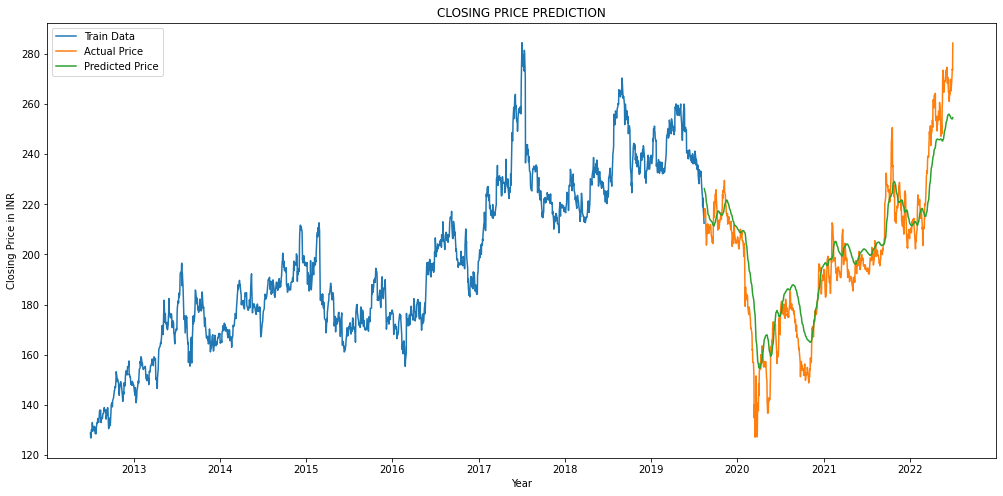

In [31]:
#Plotting the predictions
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

#Setting labels
plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in INR")
plt.title("CLOSING PRICE PREDICTION")

#Let's go
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc ="upper left")
plt.show()